In [1]:
#Imports
import pandas as pd
import numpy as np
import os
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Get run duration (max Time) from each CSV
CSV_DIR = "../data/CSV"

durations = {}
for f in os.listdir(CSV_DIR):
    if not f.lower().endswith(".csv"):
        continue
    try:
        csv_df = pd.read_csv(os.path.join(CSV_DIR, f))
        durations[f] = csv_df["Time"].max()
    except Exception as e:
        print(f"Skipped {f}: {e}")

duration_df = pd.DataFrame({
    "file_name": list(durations.keys()),
    "run_duration": list(durations.values())
})
print(f"Parsed durations for {len(duration_df)} files")
print(f"Duration range: {duration_df['run_duration'].min():.2f}s - {duration_df['run_duration'].max():.2f}s")

Parsed durations for 445 files
Duration range: 0.10s - 50.00s


In [4]:
#Load features_updated and merge with durations
df = pd.read_csv("../data/features_updated.csv")
feature_cols = [c for c in df.columns if c != "file_name"]

df = pd.merge(df, duration_df, on="file_name", how="inner")
print(f"Matched samples: {len(df)} / {len(duration_df)}")
print(f"Features to test: {len(feature_cols)}")


Matched samples: 445 / 445
Features to test: 63


In [5]:
#Correlate each feature with run duration
results = []

for feat in feature_cols:
    #Convert to numeric: anything weird becomes NaN
    x = pd.to_numeric(df["run_duration"], errors="coerce")
    y = pd.to_numeric(df[feat], errors="coerce")

    #Keep only rows where both are present
    valid = pd.DataFrame({"x": x, "y": y}).dropna()
    if len(valid) < 5:
        continue

    #Skip if either variable is constant (correlation undefined)
    if valid["x"].nunique() < 2 or valid["y"].nunique() < 2:
        continue

    r, p = stats.pearsonr(valid["x"], valid["y"])
    results.append({
        "feature": feat,
        "pearson_r": r,
        "p_value": p,
        "abs_r": abs(r),
        "n_samples": len(valid)
    })

corr_df = pd.DataFrame(results).sort_values("abs_r", ascending=False)

#drop undefined correlations
corr_df = corr_df.dropna(subset=["pearson_r", "p_value"]).reset_index(drop=True)
#ADDING FDR Correction (from my STAT 550)
from statsmodels.stats.multitest import multipletests

rejected, p_adjusted, _, _ = multipletests(
    corr_df["p_value"],
    alpha=0.05,
    method="fdr_bh"
)
corr_df["p_adjusted"] = p_adjusted
corr_df["significant_fdr"] = rejected
#Show 
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
display(corr_df)

#print how many features remained
print(f"Remaining features with defined correlation: {len(corr_df)}")

,feature,pearson_r,p_value,abs_r,n_samples,p_adjusted,significant_fdr
0,a0_rms_change_points,0.383889,4.489141e-17,0.383889,445,2.469028e-15,True
1,a1_rms_change_points,0.349940,2.894783e-14,0.349940,445,7.960654e-13,True
2,a1_spectral_flatness,0.318459,6.030924e-12,0.318459,445,1.105669e-10,True
3,a1_peaks_per_second,-0.308716,2.787930e-11,0.308716,445,3.833404e-10,True
4,a0_peaks_per_second,-0.297643,1.484987e-10,0.297643,445,1.633486e-09,True
5,a1_num_boilings,-0.283229,1.180164e-09,0.283229,445,1.081817e-08,True
6,a0_mean_time_diff,0.271284,6.024554e-09,0.271284,445,4.733578e-08,True
7,a1_mean_time_diff,0.270209,6.950020e-09,0.270209,445,4.778138e-08,True
8,a1_median_time_diff,0.267247,1.027003e-08,0.267247,445,6.276132e-08,True
9,a0_num_boilings,-0.266244,1.170966e-08,0.266244,445,6.300825e-08,True


Remaining features with defined correlation: 55


In [7]:
# Flag features correlated with run duration using FDR-adjusted significance

sig = corr_df[corr_df["significant_fdr"]]
not_sig = corr_df[~corr_df["significant_fdr"]]

print("=" * 70)
print("FEATURES CORRELATED WITH RUN DURATION (FDR q < 0.05) — consider removing")
print("=" * 70)

for _, row in sig.iterrows():
    print(f"  ✗ {row['feature']:<45} r={row['pearson_r']:+.3f}  q={row['p_adjusted']:.4f}")

print("\n" + "=" * 70)
print("FEATURES NOT SIGNIFICANT AFTER FDR (q ≥ 0.05) — safer to keep")
print("=" * 70)

for _, row in not_sig.iterrows():
    print(f"  ✓ {row['feature']:<45} r={row['pearson_r']:+.3f}  q={row['p_adjusted']:.4f}")

print(f"\nTotal: {len(not_sig)} features safe (by FDR)")

FEATURES CORRELATED WITH RUN DURATION (FDR q < 0.05) — consider removing
  ✗ a0_rms_change_points                          r=+0.384  q=0.0000
  ✗ a1_rms_change_points                          r=+0.350  q=0.0000
  ✗ a1_spectral_flatness                          r=+0.318  q=0.0000
  ✗ a1_peaks_per_second                           r=-0.309  q=0.0000
  ✗ a0_peaks_per_second                           r=-0.298  q=0.0000
  ✗ a1_num_boilings                               r=-0.283  q=0.0000
  ✗ a0_mean_time_diff                             r=+0.271  q=0.0000
  ✗ a1_mean_time_diff                             r=+0.270  q=0.0000
  ✗ a1_median_time_diff                           r=+0.267  q=0.0000
  ✗ a0_num_boilings                               r=-0.266  q=0.0000
  ✗ a0_median_time_diff                           r=+0.266  q=0.0000
  ✗ a0_sum_peak_magnitude                         r=+0.253  q=0.0000
  ✗ a1_sum_peak_magnitude                         r=+0.243  q=0.0000
  ✗ a0_rms                    

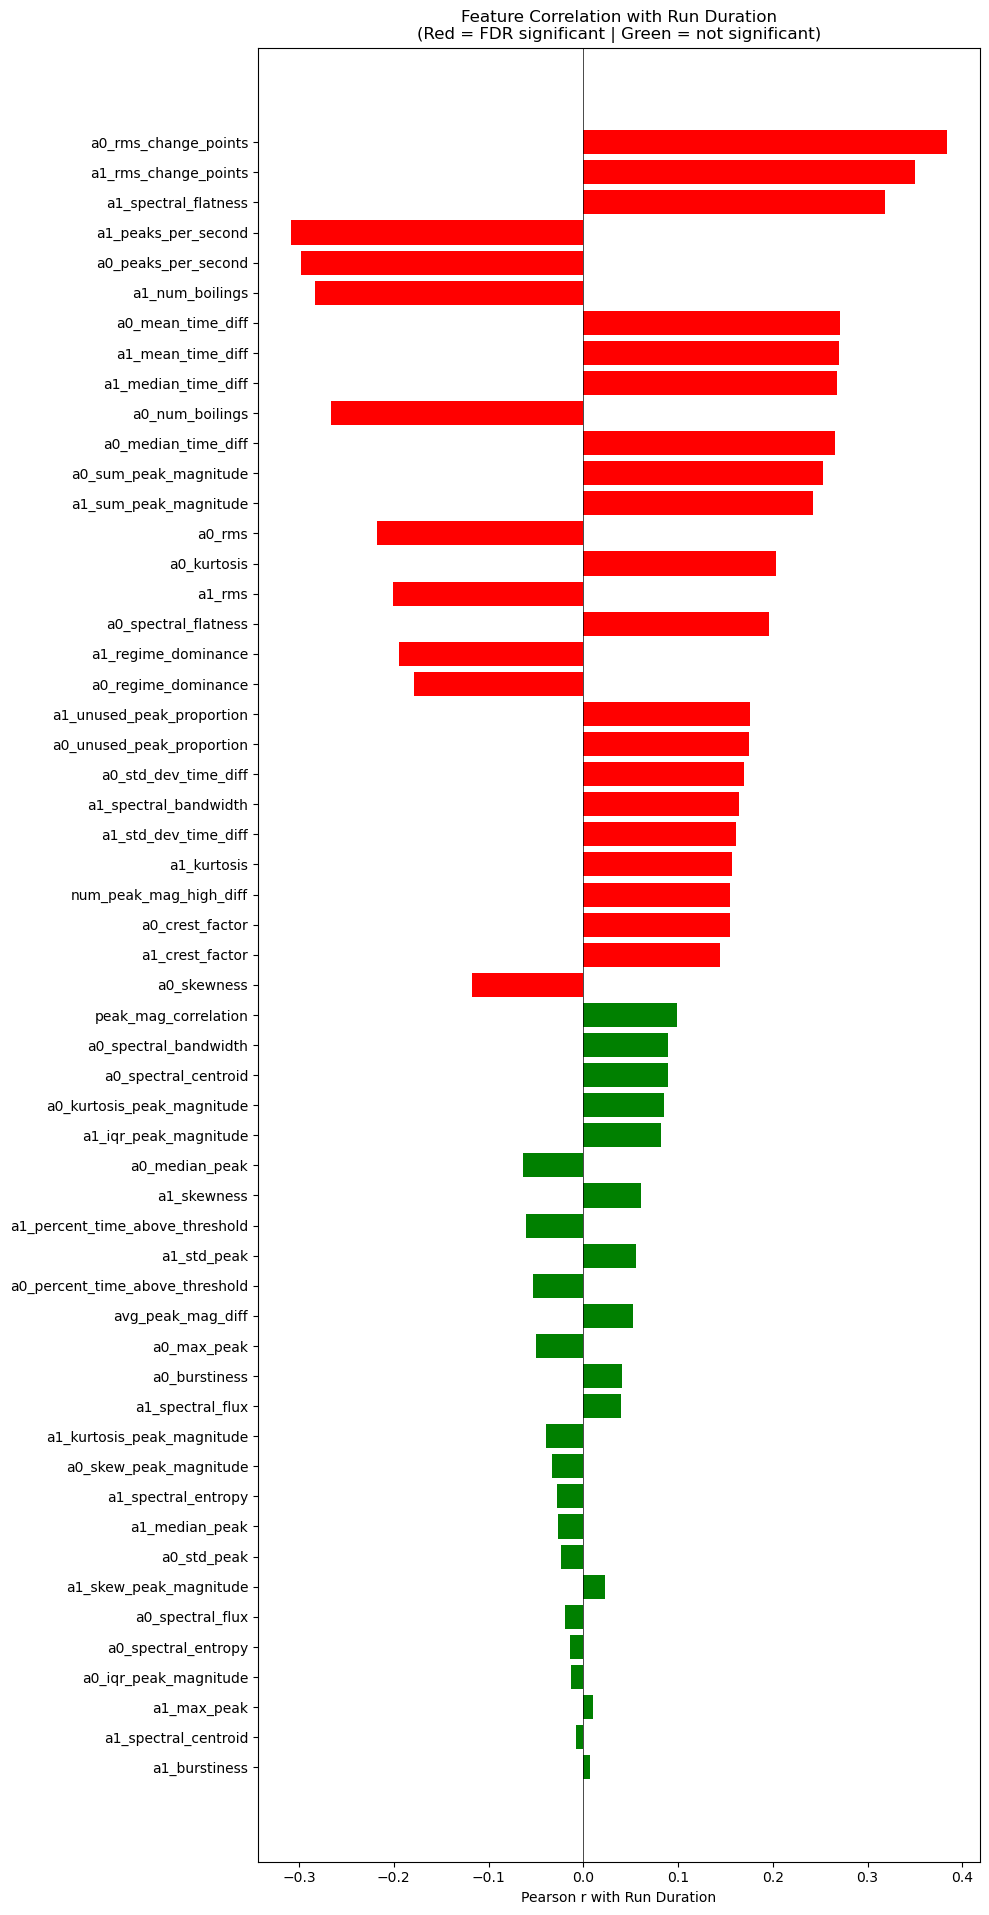

In [10]:
#Bar chart of correlations

corr_df_sorted = corr_df.sort_values("abs_r", ascending=True)

fig, ax = plt.subplots(figsize=(10, max(6, len(corr_df_sorted) * 0.35)))

# Color by FDR significance
colors = ["red" if sig else "green" 
          for sig in corr_df_sorted["significant_fdr"]]

ax.barh(
    corr_df_sorted["feature"], 
    corr_df_sorted["pearson_r"], 
    color=colors
)

ax.axvline(x=0, color="black", linewidth=0.5)
ax.set_xlabel("Pearson r with Run Duration")
ax.set_title("Feature Correlation with Run Duration\n(Red = FDR significant | Green = not significant)")

plt.tight_layout()
plt.savefig("time_duration_correlation.png", dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
#Save results
# corr_df["flagged_for_removal"] = corr_df["p_value"] < alpha
# corr_df.to_csv("feature_duration_correlation.csv", index=False)
# print("\nSaved: feature_duration_correlation.csv")

# # List of safe feature names (for easy copy into your clustering code)
# safe_features = not_sig["feature"].tolist()
# print(f"\nSafe features list ({len(safe_features)}):")
# print(safe_features)